# Lesson 4 - Comparing to p2108

In [1]:
from ITS.ITU.PSeries import P2108
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from sklearn.linear_model import LinearRegression

In [2]:
L__dB = P2108.TerrestrialStatisticalModel(3.5, 0.95, 50)

In [3]:
print(L__dB)

30.030650175561295


In [4]:
clutter_height_mean = 8 ## meters
clutter_height_std = 4.5 ## meters

In [5]:
## bring in LiDAR data (same as lesson 2)
dataset_terrain = rasterio.open("./data/MartinAcres.dtm.tif")
dataset_surface = rasterio.open("./data/MartinAcres.dsm.tif")
band1_terrain = dataset_terrain.read(1)
band1_surface = dataset_surface.read(1)
## set map and LiDAR bounds (same as lesson 2)
left, bottom, right, top = dataset_terrain.bounds
left_deg, bottom_deg, right_deg, top_deg = (-105.2869255, 39.9747967, -105.2343079, 40.0019534)
## for converting lat and long degrees into meters (same as lesson 2)
meters_per_lat = 111319.49 
meters_per_long = 85263.24 ## only valid at latitudes of 40 degrees

In [6]:
low_file_name = "./data/MartinAcresLow_3500.MartinAcres.csv"
high_file_name = "./data/MartinAcresHigh_3500.MartinAcres.csv"
low_df = pd.read_csv(low_file_name)
high_df = pd.read_csv(high_file_name)

In [7]:
## functions to convert lat and long to meters
def convert_lat_to_meters(lat):
    lat_dif = top_deg - lat
    vert_dif_m = lat_dif * meters_per_lat
    return vert_dif_m

def convert_long_to_meters(long):
    long_dif = long - left_deg
    horz_dif_m = long_dif * meters_per_long
    return horz_dif_m

## create new columns by mapping the conversion function to lat or long column
low_df["RxX__meter"] = low_df["RxLon"].map(convert_long_to_meters)
low_df["RxY__meter"] = low_df["RxLat"].map(convert_lat_to_meters)
low_df["TxX__meter"] = low_df["TxLon"].map(convert_long_to_meters)
low_df["TxY__meter"] = low_df["TxLat"].map(convert_lat_to_meters)

In [8]:
## do the same for the High dataframe
high_df["RxX__meter"] = high_df["RxLon"].map(convert_long_to_meters)
high_df["RxY__meter"] = high_df["RxLat"].map(convert_lat_to_meters)
high_df["TxX__meter"] = high_df["TxLon"].map(convert_long_to_meters)
high_df["TxY__meter"] = high_df["TxLat"].map(convert_lat_to_meters)

In [9]:
## read in Martin Acres map image
##  image from www.openstreetmap.org
martin_acres_map = plt.imread('./images/martin_acres_map.png')

## set the map bounding box (in meters)
BBox = (0,  right-left,      
        top-bottom,  0)

In [10]:
## use LiDAR to add antenna altitude to the dataframes for TX and RX antenna
def antenna_altitude(x, y, antenna_height, lidar_elev_band):
    elev = lidar_elev_band[int(y)][int(x)]
    return elev + antenna_height

low_df["alt_rx__meter"] = low_df.apply(lambda row: antenna_altitude(row.RxX__meter, row.RxY__meter, row.h_rx__meter, band1_terrain), axis=1)
low_df["alt_tx__meter"] = low_df.apply(lambda row: antenna_altitude(row.TxX__meter, row.TxY__meter, row.h_tx__meter, band1_terrain), axis=1)
high_df["alt_rx__meter"] = high_df.apply(lambda row: antenna_altitude(row.RxX__meter, row.RxY__meter, row.h_rx__meter, band1_terrain), axis=1)
high_df["alt_tx__meter"] = high_df.apply(lambda row: antenna_altitude(row.TxX__meter, row.TxY__meter, row.h_tx__meter, band1_terrain), axis=1)

## RX elevation angle = arcsin( (tx_altitude - rx_altitude) / Hypotenuse distance )
##  returns Rx elevation angle in degrees
def rx_elev_angle(alt_rx, alt_tx, d):
    soh = np.abs(alt_tx - alt_rx) / (d*1000)
    angle_deg = np.arcsin(soh)*360/(np.pi*2) 
    return angle_deg

## calculate the rx antenna angle and add a new column to the dataframe
high_df["rx_angle__deg"] = high_df.apply(lambda row: rx_elev_angle(row.alt_rx__meter, row.alt_tx__meter, row.d_3d__km), axis=1)
low_df["rx_angle__deg"] = low_df.apply(lambda row: rx_elev_angle(row.alt_rx__meter, row.alt_tx__meter, row.d__km), axis=1)

In [11]:
def convert_gps_to_meters(lat, long):
    lat_dif = top_deg - lat
    long_dif = long - left_deg
    vert_dif_m = lat_dif * meters_per_lat
    horz_dif_m = long_dif * meters_per_long
    return (vert_dif_m, horz_dif_m)

bway_n = convert_gps_to_meters(39.99741,-105.26273)
bway_s = convert_gps_to_meters(39.98587,-105.25248)

In [12]:
## this function finds the intersection of the ray path with broadway
##  it returns the distance of the intersection to the RX point
##  input tx and rx points and Broadway start and end points.
def m_intersect(tx_m, rx_m, line_s_m, line_e_m):
    rise1 = tx_m[0] - rx_m[0]
    run1 = tx_m[1] - rx_m[1]
    m1 = rise1 / run1 ## find the slope of the first line
    
    rise2 = line_s_m[0] - line_e_m[0]
    run2 = line_s_m[1] - line_e_m[1]
    m2 = rise2 / run2 ## find the slope of the second line
    
    ## x and y are the intersection point (in meters)
    ## x = (m1*b - a - m2*d + c) / (m1 - m2)
    x = (m1*tx_m[1] - tx_m[0] - m2*line_s_m[1] + line_s_m[0]) / (m1 - m2)
    y = m1*(x-tx_m[1]) + tx_m[0]
    # print(m1, m2, x, y)
    dist_from_rx = np.sqrt(np.square(x - rx_m[1]) + np.square(y - rx_m[0]))
    # print(dist_from_rx)
    return dist_from_rx

## add new column to DataFrame, the distance from RX to Broadway
low_df["horizontal_d__meter"] = low_df.apply(lambda row: m_intersect((row.TxY__meter, row.TxX__meter), (row.RxY__meter, row.RxX__meter), bway_s, bway_n), axis=1)
high_df["horizontal_d__meter"] = high_df.apply(lambda row: m_intersect((row.TxY__meter, row.TxX__meter), (row.RxY__meter, row.RxX__meter), bway_s, bway_n), axis=1)

In [13]:
h_c = clutter_height_mean + 2*clutter_height_std

def clutter_distance(horizontal_d, rep_clutter_height, rx_angle):
    return min(horizontal_d, rep_clutter_height/np.sin(rx_angle*(2*np.pi)/360)) ## 2*pi/360 converts from degrees to radians

## add the new clutter distance columns
low_df["clutter_d__meter"] = low_df.apply(lambda row: clutter_distance(row.horizontal_d__meter, h_c, row.rx_angle__deg), axis=1)
high_df["clutter_d__meter"] = high_df.apply(lambda row: clutter_distance(row.horizontal_d__meter, h_c, row.rx_angle__deg), axis=1)

In [14]:
## concatinate the high and low dataframes
df1 = high_df[["clutter_d__meter", "L_excess__db", "f__mhz", "d__km"]]
df2 = low_df[["clutter_d__meter", "L_excess__db", "f__mhz", "d__km"]]
frames = [df1, df2]
full_df = pd.concat(frames)

## perform the linear regression on the data
linear_regression = LinearRegression()
linear_regression.fit(np.array(np.log10(full_df["clutter_d__meter"])).reshape(-1,1), full_df["L_excess__db"])
y_int = linear_regression.intercept_
slope = linear_regression.coef_[0]
print("a = {:.2f} \nb = {:.2f}".format(slope, y_int))
print("L_cm = {:.2f} * log10(r_c) + {:.2f}".format(slope, y_int))

a = 13.71 
b = -9.80
L_cm = 13.71 * log10(r_c) + -9.80


### Plot with the fit line with the measurement data

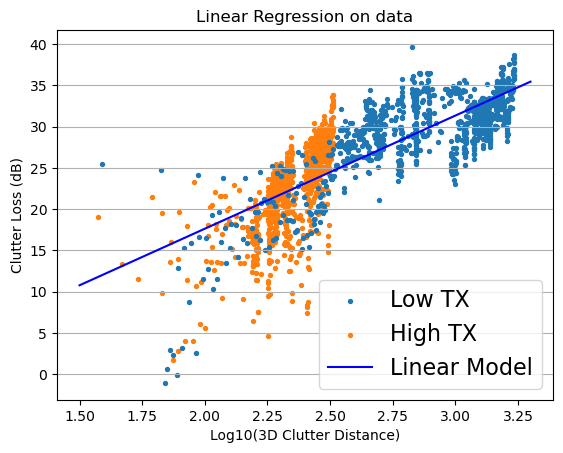

In [15]:
plt.scatter(np.log10(low_df["clutter_d__meter"]), low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
plt.scatter(np.log10(high_df["clutter_d__meter"]), high_df["L_excess__db"], label='High TX', s=8, zorder=0)

## add the regression line
z_point = (1.5, slope*1.5 + y_int)
n_point = (3.3, slope*3.3 + y_int)

plt.plot([z_point[0], n_point[0]],[z_point[1], n_point[1]], c='b', label="Linear Model")
plt.xlabel('Log10(3D Clutter Distance)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Linear Regression on data')
  
plt.legend(fontsize=16)
plt.gca().yaxis.grid(True)
plt.show()

### Transform back to linear units

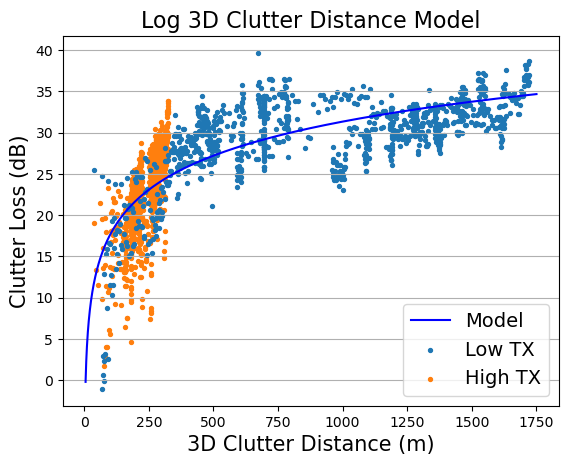

In [16]:
full_x = np.linspace(5,1750,2000)
full_y = slope*np.log10(full_x) + y_int
plt.plot(full_x, full_y, label='Model', c='b')

plt.scatter(low_df["clutter_d__meter"], low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
plt.scatter(high_df["clutter_d__meter"], high_df["L_excess__db"], label='High TX', s=8, zorder=0)

plt.xlabel('3D Clutter Distance (m)', fontsize=15)
plt.ylabel('Clutter Loss (dB)', fontsize=15)
plt.title('Log 3D Clutter Distance Model', fontsize=16)
plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

### Your median clutter loss model is...

In [17]:
print("L_cm = {:.2f} * log10(r_c) + {:.2f}".format(slope, y_int))

L_cm = 13.71 * log10(r_c) + -9.80


### Plot the residuals of the regression model 

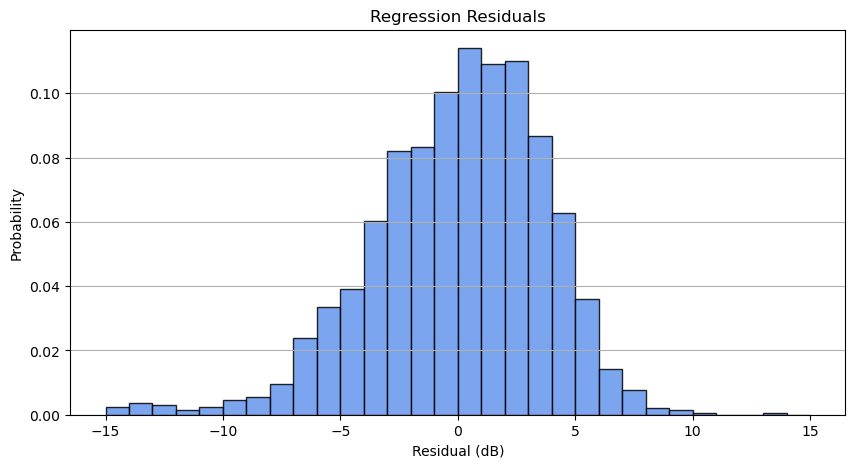

In [18]:
## define the clutter model
def model(r_c):
    return slope * np.log10(r_c) + y_int

## add column for predicted loss based on the clutter model
full_df["pred_loss"] = full_df["clutter_d__meter"].map(model)

## add a column for the prediction error
full_df["error"] = full_df.apply(lambda row: row.L_excess__db - row.pred_loss, axis=1)

## plot
plt.rcParams["figure.figsize"] = (10,5)

# the histogram of the residuals
n, bins, patches = plt.hist(full_df["error"], np.linspace(-15,15,31), density=True, facecolor='cornflowerblue', alpha=.85, edgecolor='black')


plt.xlabel('Residual (dB)')
plt.ylabel('Probability')
plt.title('Regression Residuals')
plt.gca().yaxis.grid(True)
plt.show()

### Plot model with 10%, 50%, and 90% variability bounds

In [19]:
## sort errors and find 10% and 90% bounds
full_N = len(full_df)
full_sorted_x = np.sort(full_df["error"])
full_sorted_y = np.arange(full_N) / float(full_N)
idx_10 = np.where(full_sorted_y > 0.1)[0][0]
idx_90 = np.where(full_sorted_y > 0.9)[0][0]

print("10% is at + {:.1f} dB".format(full_sorted_x[idx_10]))
print("90% is at + {:.1f} dB".format(full_sorted_x[idx_90]))

10% is at + -4.7 dB
90% is at + 4.4 dB


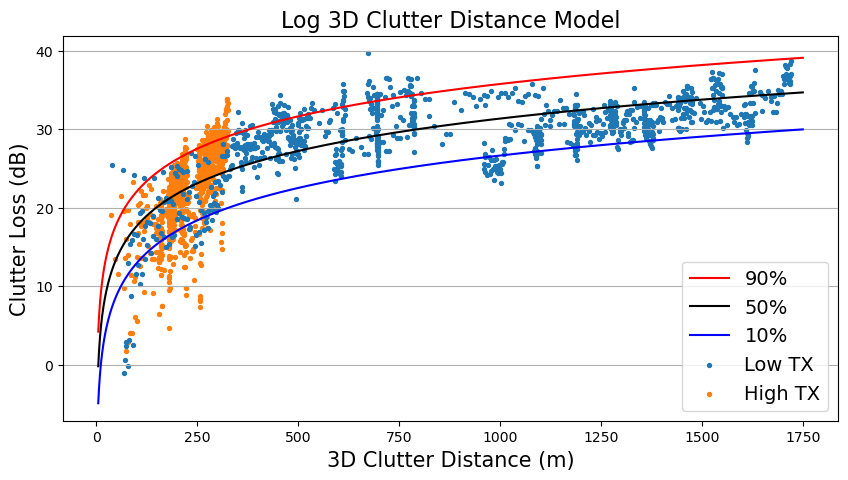

In [20]:
full_x = np.linspace(5,1750,2000)
full_y = slope*np.log10(full_x) + y_int
## plot 90%
plt.plot(full_x, full_y + full_sorted_x[idx_90], label='90%', c='r')
## plot median
plt.plot(full_x, full_y, label='50%', c='black')
## plot 10%
plt.plot(full_x, full_y + full_sorted_x[idx_10], label='10%', c='b')


plt.scatter(low_df["clutter_d__meter"], low_df["L_excess__db"], label='Low TX', s=8, zorder=1)
plt.scatter(high_df["clutter_d__meter"], high_df["L_excess__db"], label='High TX', s=8, zorder=0)

plt.xlabel('3D Clutter Distance (m)', fontsize=15)
plt.ylabel('Clutter Loss (dB)', fontsize=15)
plt.title('Log 3D Clutter Distance Model', fontsize=16)
plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()

The 10%, 50%, and 90% curves capture the location varibility present within the measurements. The location variability causes a +/- 4.5 dB spread around the median. These values are included in the statistical propagation model that you just found.

$$\Huge L_c = 13.7*\text{log}_{10}(r_c) - 9.8 \pm 4.5 \text{dB}$$

Well done, you've created a statistical clutter model based on propagation measurements and LiDAR. In the next less you'll compare your model to a well known clutter model p2108. 

End of Lesson 3

In [21]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1978 entries, 0 to 1023
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   clutter_d__meter  1978 non-null   float64
 1   L_excess__db      1978 non-null   float64
 2   f__mhz            1978 non-null   int64  
 3   d__km             1978 non-null   float64
 4   pred_loss         1978 non-null   float64
 5   error             1978 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 108.2 KB


In [22]:
greater_p25_df = full_df.loc[(full_df["d__km"] >= 0.25)]

In [23]:
greater_p25_df["p2108"] = greater_p25_df.apply(lambda row: P2108.TerrestrialStatisticalModel(row.f__mhz/1000, row.d__km, 50), axis=1)


/tmp/ipykernel_1879/2556620317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  greater_p25_df["p2108"] = greater_p25_df.apply(lambda row: P2108.TerrestrialStatisticalModel(row.f__mhz/1000, row.d__km, 50), axis=1)


In [24]:
greater_p25_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1960 entries, 0 to 1023
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   clutter_d__meter  1960 non-null   float64
 1   L_excess__db      1960 non-null   float64
 2   f__mhz            1960 non-null   int64  
 3   d__km             1960 non-null   float64
 4   pred_loss         1960 non-null   float64
 5   error             1960 non-null   float64
 6   p2108             1960 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 122.5 KB


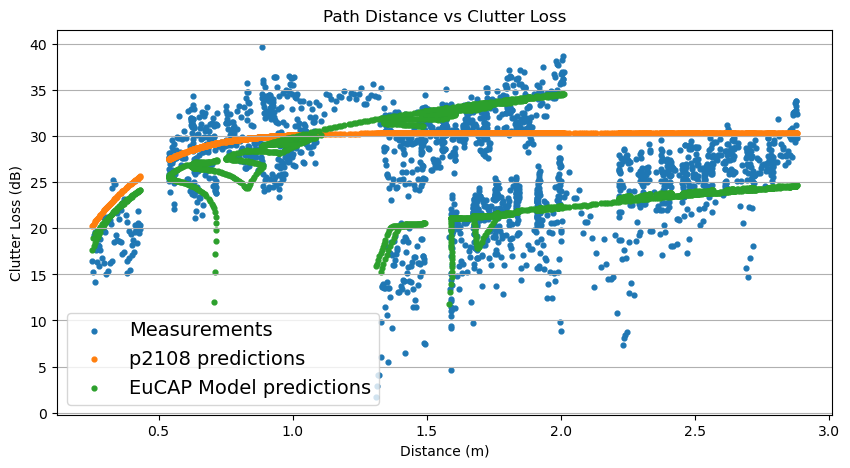

In [25]:
plt.scatter(greater_p25_df["d__km"], greater_p25_df["L_excess__db"], label='Measurements', s=12)
plt.scatter(greater_p25_df["d__km"], greater_p25_df["p2108"], label='p2108 predictions', s=12)
plt.scatter(greater_p25_df["d__km"], greater_p25_df["pred_loss"], label='EuCAP Model predictions', s=12)

plt.xlabel('Distance (m)')
plt.ylabel('Clutter Loss (dB)')
plt.title('Path Distance vs Clutter Loss')

plt.legend(fontsize=14)
plt.gca().yaxis.grid(True)
plt.show()